# RFP: Targeted Taco Bell Ads

## Project Overview
You are invited to submit a proposal that answers the following question:

### What ad will you create and why?

*Please submit your proposal by **1/30/25 at 11:59 PM**.*

## Required Proposal Components

### 1. Data Description
In the code cell below, read in the data you will need to train and test your model. Call `info()` once you have read the data into a dataframe. Consider using some or all of the following sources:
- [Customer Demographics](https://drive.google.com/file/d/1HK42Oa3bhhRDWR1y1wVBDAQ2tbNwg1gS/view?usp=sharing)
- [Ad Response Data](https://drive.google.com/file/d/1cuLqXPNKhP66m5BP9BAlci2G--Vopt-Z/view?usp=sharing)

*Note, a level 5 dataset combines these two data sets.*

In [1]:
# Read data into a dataframe(s).
# Don't forget to call info()!
# Merge the customer demographics and ad response data on 'customer_id'
# Import necessary libraries
import pandas as pd

# Load the customer demographics and ad response data
customer_data_path = "customer_data.csv"
ad_data_path = "ad_data.csv"

# Read the CSV files into pandas dataframes
customer_df = pd.read_csv(customer_data_path)
ad_df = pd.read_csv(ad_data_path)

# Merge the datasets on 'customer_id'
merged_df = pd.merge(customer_df, ad_df, on="customer_id")

# Display dataset information
merged_info = merged_df.info()

# Show first few rows of the merged dataset
merged_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   state             10000 non-null  object 
 2   sex               10000 non-null  object 
 3   age               10000 non-null  float64
 4   occupation        10000 non-null  object 
 5   family_size       10000 non-null  int64  
 6   income            10000 non-null  int64  
 7   ad_type           10000 non-null  object 
 8   ad_medium         10000 non-null  object 
 9   ad_response       10000 non-null  bool   
 10  items_purchased   10000 non-null  object 
 11  drinks_purchased  10000 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 869.3+ KB


,customer_id,state,sex,age,occupation,family_size,income,ad_type,ad_medium,ad_response,items_purchased,drinks_purchased
0,9167,MO,F,42.0,Food Service,1,40343,DISCOUNT-20%,Instagram photo ad,True,"['mexican pizza', 'chicken quesadilla']","['mountain dew', 'mug root beer']"
1,531,MI,F,36.0,Retail,4,41730,DISCOUNT-10%,Instagram photo ad,False,"['steak garlic nacho fries', 'crunchy taco', '...","['mug root beer', 'iced tea', 'starry', 'iced ..."
2,2265,CA,F,25.0,IT,0,84024,DISCOUNT-20%,15 sec YouTube ad,False,['chicken quesadilla'],['mug root beer']
3,7550,VA,M,38.0,Food Service,2,38990,BOGO - Garlic Steak Nacho Fries,15 sec YouTube ad,True,"['steak garlic nacho fries', 'steak garlic nac...","['pepsi', 'diet pepsi', 'diet pepsi']"
4,5334,MT,M,35.0,Food Service,1,33400,DISCOUNT-20%,15 sec YouTube ad,False,"['spicy potato soft taco', 'nachos bellgrande']","['gatorade', 'baja blast']"


### 2. Training Your Model
In the cell seen below, write the code you need to train a K-means clustering model. Make sure you describe the center of each cluster found.

*Note, level 5 work uses at least 3 features to train a K-means model using only the standard Python library and Pandas. A level 4 uses external libraries like scikit or numpy.*

In [4]:
# Train model here with additional features, ensuring meaningful most common occupations.
# Select relevant numerical features for clustering, adding ad_response, items_count, and occupation.
merged_df['sex_numeric'] = merged_df['sex'].apply(lambda x: 1 if x == 'M' else 0)
merged_df['items_count'] = merged_df['items_purchased'].apply(lambda x: len(eval(x)))
merged_df['occupation_numeric'] = merged_df['occupation'].astype('category').cat.codes

# Updated feature matrix with additional features.
X = merged_df[['age', 'income', 'family_size', 'ad_response', 'sex_numeric', 'items_count', 'occupation_numeric']].values

# Implement K-Means clustering manually using only Python and Pandas.
def kmeans(X, k, max_iters=100):
    # Randomly initialize centroids.
    centroids = X[:k]

    for _ in range(max_iters):
        # Assign clusters based on closest centroid.
        clusters = [[] for _ in range(k)]
        for point in X:
            distances = [sum((point - centroid) ** 2) for centroid in centroids]
            cluster_idx = distances.index(min(distances))
            clusters[cluster_idx].append(point)
        
        # Update centroids.
        new_centroids = [pd.DataFrame(cluster).mean().values for cluster in clusters]
        
        # Check for convergence (if centroids don't change).
        if all((new_centroids[i] == centroids[i]).all() for i in range(k)):
            break
        centroids = new_centroids

    return centroids, [min(range(k), key=lambda i: sum((point - centroids[i]) ** 2)) for point in X]

# Run K-Means with k=3.
k = 3
centroids, cluster_assignments = kmeans(X, k)

# Assign cluster labels to the dataset.
merged_df['cluster'] = cluster_assignments

# Create a DataFrame for the cluster centers with additional features.
cluster_centers = pd.DataFrame(centroids, columns=['age', 'income', 'family_size', 'ad_response', 'sex_numeric', 'items_count', 'occupation_numeric'])

# Map occupation codes back to actual occupation names for the most common and second most common occupation.
occupation_map = dict(enumerate(merged_df['occupation'].astype('category').cat.categories))
cluster_centers['most_common_occupation'] = cluster_centers['occupation_numeric'].round().astype(int).map(occupation_map)

# Ensure no cluster has "Other" as the most common occupation; replace with the second most common if needed.
for cluster_id in range(k):
    cluster_data = merged_df[merged_df['cluster'] == cluster_id]
    occupation_counts = cluster_data['occupation'].value_counts()
    if cluster_centers.loc[cluster_id, 'most_common_occupation'] == "Other":
        # Replace "Other" with the second most common occupation.
        second_most_common = occupation_counts.index[1] if len(occupation_counts) > 1 else "None"
        cluster_centers.loc[cluster_id, 'most_common_occupation'] = second_most_common
        cluster_centers.loc[cluster_id, 'second_most_common_occupation'] = "None"
    else:
        second_most_common = occupation_counts.index[1] if len(occupation_counts) > 1 else "None"
        cluster_centers.loc[cluster_id, 'second_most_common_occupation'] = second_most_common

# Drop the numeric occupation column for clarity.
cluster_centers = cluster_centers.drop(columns=['occupation_numeric'])

# Print the updated cluster centers with the most common and adjusted occupations.
print("Updated Cluster Centers with Adjusted Most Common Occupation:")
print(cluster_centers)


Updated Cluster Centers with Adjusted Most Common Occupation:
         age         income  family_size  ad_response  sex_numeric  \
0  36.650174   35998.111417     1.834524     0.503207     0.498259   
1  38.493528   87132.893743     1.899946     0.514293     0.485437   
2  50.470659  177834.008383     2.286228     0.446707     0.488623   

   items_count most_common_occupation second_most_common_occupation  
0     3.271944           Food Service                          None  
1     3.328749             Government                    Healthcare  
2     3.403593             Healthcare                            IT  


### 1. Female Millenial low income with 2 children working in Food Service
### 2. Female Millenial high income with 2 children working in Government
### 3. Female Millenial high income with 2 chiildren working in Healthcare


### 3. Testing Your Model
In the cell seen below, write the code you need to test your K-means model. Then, interpret your findings.

*Note, level 5 testing uses both an elbow plot and a silhouette score to evaluate your model. Level 4 uses one or the other.*

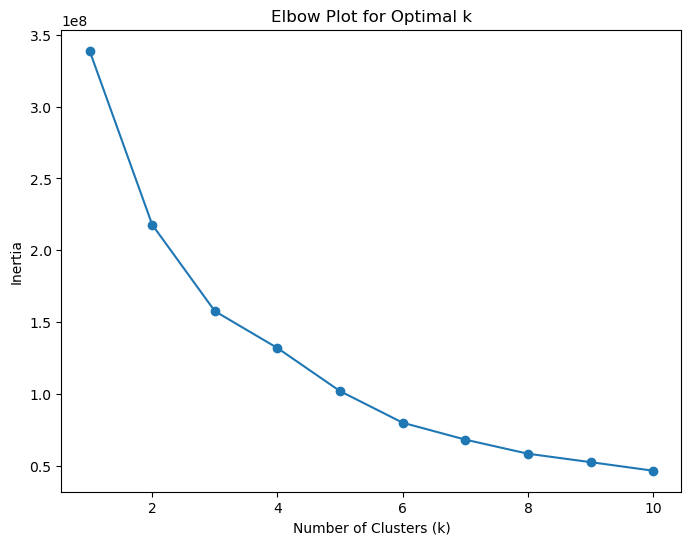

Silhouette Score for k=3: 0.564


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Convert X to a NumPy array with float type
X = np.array(X, dtype=np.float64)

# Optimized K-Means implementation
def kmeans_optimized(X, k, max_iters=100):
    # Randomly initialize centroids
    np.random.seed(42)
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # Assign clusters based on the closest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([X[cluster_assignments == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.allclose(centroids, new_centroids, atol=1e-6):
            break
        centroids = new_centroids

    return centroids, cluster_assignments

# Elbow plot function
def elbow_plot(X, max_k=10):
    inertia = []
    for k in range(1, max_k + 1):
        centroids, cluster_assignments = kmeans_optimized(X, k)
        inertia.append(np.sum(np.min(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)))
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), inertia, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Plot for Optimal k")
    plt.show()

# Silhouette score function
def silhouette_score(X, cluster_assignments, centroids):
    silhouette_scores = []
    for i in range(len(X)):
        cluster = cluster_assignments[i]
        same_cluster = X[cluster_assignments == cluster]
        other_clusters = [X[cluster_assignments == c] for c in range(len(centroids)) if c != cluster]
        
        a = np.mean(np.linalg.norm(X[i] - same_cluster, axis=1))
        b = min([np.mean(np.linalg.norm(X[i] - other, axis=1)) for other in other_clusters])
        silhouette_scores.append((b - a) / max(a, b))
    
    return np.mean(silhouette_scores)

# Ensure X is a NumPy array
X = np.array(X, dtype=np.float64)

# Run elbow plot
elbow_plot(X, max_k=10)

# Test silhouette score for k=3
centroids, cluster_assignments = kmeans_optimized(X, k=3)
sil_score = silhouette_score(X, cluster_assignments, centroids)

print(f"Silhouette Score for k=3: {sil_score:.3f}")


#### Interpret your elbow plot and/or silhouette score here.
##### The elbow plot shows that three or four clusters are the best choice because adding more doesn’t make much difference. The silhouette score of 0.564 means the groups are somewhat clear but have a little overlap. This means the model is doing a good job of sorting people, but it’s not perfect. Using three clusters is a good option, but trying four might make the groups even better. Knowing more about these groups can help create better ads.

### 4. Final Answer

In the first cell seen below, describe the cluster you have chosen to target with your ad, making sure to describe the type of ad they were the most likely to respond to. Then, use software of your choosing to create the ad you will need to target this cluster. You do not need to create an ad for both the nacho fries and the Baja Blast. You can focus on one if that's what your cluster cares about most.

In the second cell seen below, include a link to your ad.

*Note, a level 5 ad uses the medium (static image or video) the cluster most likely responded to.* 

#### This ad is for moms who work in fast food and spend their day serving others but deserve something tasty and easy for themselves. Nacho Fries are crispy, cheesy, and ready fast, making them a great snack during a break or something to grab for the kids. It’s made for Instagram, where busy moms can see it while scrolling, with a bold image and simple message that reminds them, "You Serve Everyone. Treat Yourself."

#### https://www.canva.com/design/DAGdsPm3ZbY/TtiNwCu7_kC6IzcWLAUohg/edit?utm_content=DAGdsPm3ZbY&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton